<a href="https://colab.research.google.com/github/ludwigwittgenstein2/Research/blob/master/BERT_Question_Answering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Question Answering with Fine-Tuned BERT 
                        by Rick Rejeleene

1) BERT Input Format 

2) Start & End Token Classifiers


In [ ]:
#Install HuggingFace Transformer Library 

!pip install transformers

     |████████████████████████████████| 1.3MB 2.7MB/s 
     |████████████████████████████████| 2.9MB 17.0MB/s 
     |████████████████████████████████| 1.1MB 29.1MB/s 
     |████████████████████████████████| 890kB 17.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=1dd271321aa732f4c79a98e43891a4d76cbd0c9cce81708daa6a6854a8b748a2
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
#Load Fine-Tuned BERT-Large

#https://huggingface.co/transformers/pretrained_models.html
#Contains Pre-trained models, large uncased means, pre trained on lower case english text
#BERT Large is fine tuned for SQuaD benchmark
#BERT-Large has 24 layers, embedding size 1024 and 340 M parameters


from transformers import BertForQuestionAnswering

model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')


In [ ]:
#Import Pytorch
import torch

In [ ]:
#Load Tokenizer 
#We load from BERT-base uncased 

from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

In [ ]:
#We can ask a question 

question = "How many parameters does BERT-large have?"
answer_text = "BERT-large is really big... it has 24 layers and an embedding size of 1024 for a total of 340 parameters! Size is 1.34 GB, it takes a couple of minutes"

In [ ]:
# Both Question and Answer_Text is fed into BERT tokenizer
# Concantenate them together and feed them in [SEP] token between them


input_ids = tokenizer.encode(question, answer_text)
print('The input has a total of {:} tokens.'.format(len(input_ids)))

The input has a total of 54 tokens.


In [ ]:
#We want to see what the Tokenizer is doing, 
#We want only IDs from BERT

tokens = tokenizer.convert_ids_to_tokens(input_ids) 
#In Each Token, and the ID

for token, id in zip(tokens, input_ids):
  #If we find id as [SEP], we add some space around it
  if id == tokenizer.sep_token_id:
    print('')
    #Print token string and its ID in two columns
  print('{:<12}{:>6}'.format(token,id))
  
  if id == tokenizer.sep_token_id: 
    print('')



[CLS]          101
how           2129
many          2116
parameters   11709
does          2515
bert         14324
-             1011
large         2312
have          2031
?             1029

[SEP]          102

bert         14324
-             1011
large         2312
is            2003
really        2428
big           2502
.             1012
.             1012
.             1012
it            2009
has           2038
24            2484
layers        9014
and           1998
an            2019
em            7861
##bed         8270
##ding        4667
size          2946
of            1997
102           9402
##4           2549
for           2005
a             1037
total         2561
of            1997
340          16029
parameters   11709
!              999
size          2946
is            2003
1             1015
.             1012
34            4090
gb           16351
,             1010
it            2009
takes         3138
a             1037
couple        3232
of            1997
minutes   

In [ ]:
#We concantenated them together, BERT needs to distingusih them
#BERT has Special Segment embedding, One for Segment A and Segment B
#Segment A embedding needs to go into question token
#Segment B embedding needs to be added to each of answer_text 

#Transformer Library handles these with '0' and '1' for each token
#We have segment_ids from transformer library

#Look into input ids for first instance of '[SEP]' token
sep_index = input_ids.index(tokenizer.sep_token_id)

#Number of Segment A tokens includes [SEP] token
num_seg_a = sep_index + 1

#Remaining are Segment B
num_seg_b = len(input_ids) - num_seg_a

#List of 0's and 1's
segment_ids = [0] * num_seg_a + [1] * num_seg_b

#Segment_ID for every input token
assert len(segment_ids) == len(input_ids)


In [ ]:
#Let's run it through our model 
start_scores, end_scores = model(torch.tensor([input_ids]),
                                 token_type_ids=torch.tensor([segment_ids]))

In [ ]:
#Find token with highest start and end scores

answer_start = torch.argmax(start_scores)
answer_end = torch.argmax(end_scores)

#Combine tokens in answer and print it out 
answer = ''.join(tokens[answer_start:answer_end+1])
print('Answer:"'+answer+'"')

Answer:"340"


In [ ]:
#We can reconstruct words that got broken down into subwords 

answer = tokens[answer_start]

#Select remaining answer tokens and join with whitespace
for i in range(answer_start+1, answer_end+1):

  #If found subword, then recombine it with previous token
  if tokens[i][0:2] == '##':
    answer += tokens[i][2:]
  #If not, add space between token  
  else: 
      answer += '' + tokens[i]
print('Answer:"'+answer+'"')


Answer:"340"


In [ ]:
#Visualizing Scores using Seaborn

import matplotlib.pyplot as plt 
import seaborn as sns 

sns.set(style='darkgrid')

plt.rcParams["figure.figsize"] = (16, 8)



In [ ]:
#We take from Pytorch Tensors and then convert them into 1D numpy arrays
s_scores = start_scores.detach().numpy().flatten()
e_scores = end_scores.detach().numpy().flatten()

#Token as x axis, they'll need to be unique
token_labels = [] 
for (i, token) in enumerate(tokens): token_labels.append('{:} - {:>2}'.format(token, i))


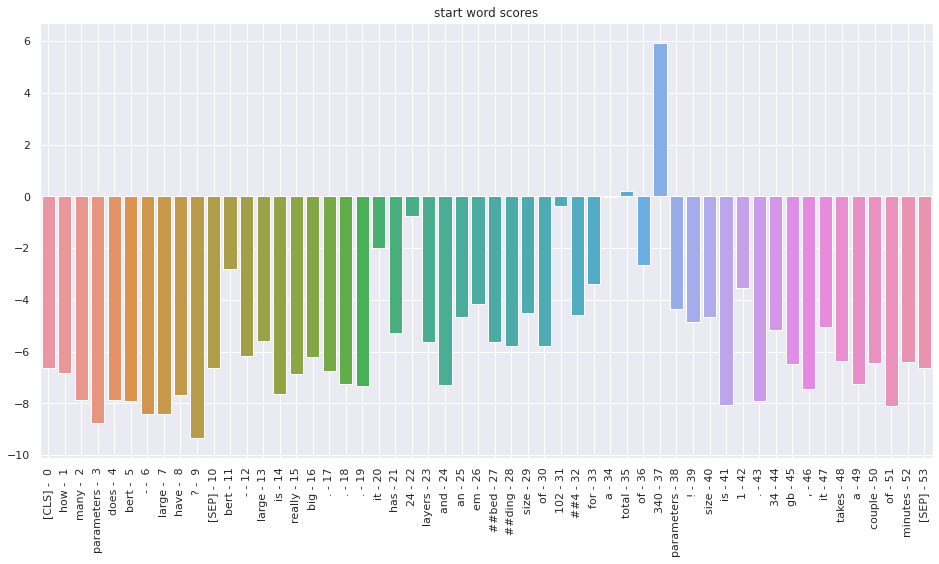

In [ ]:
#Create a Bar plot to show start word score for all tokens
ax = sns.barplot(x=token_labels, y=s_scores, ci=None)

#Turn xlabels vertical 
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

#Turn on vertical grid to help align words to score
ax.grid(True)
plt.title("start word scores")
plt.show()

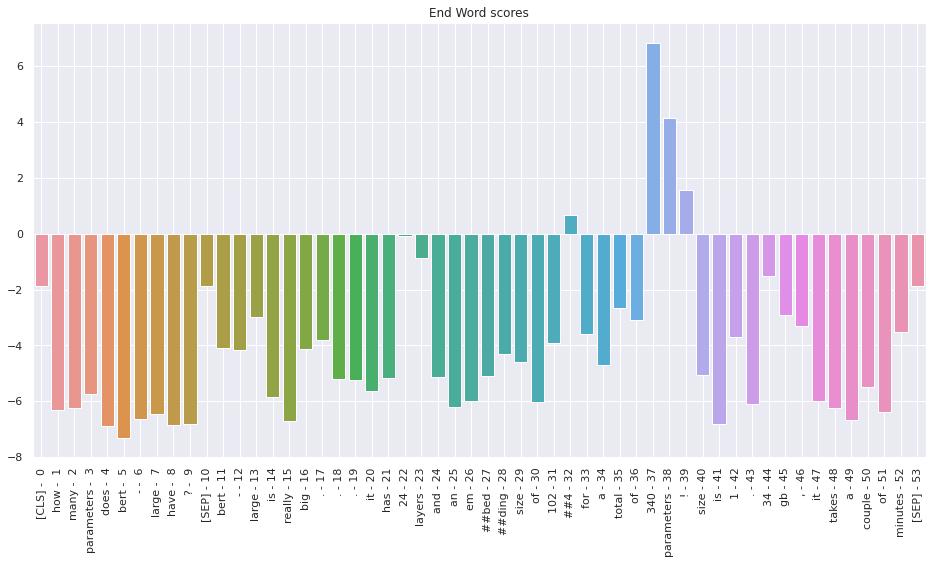

In [ ]:
#Another Bar Plot for scoring end Word
ax = sns.barplot(x=token_labels, y=e_scores, ci=None)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
ax.grid(True)
plt.title("End Word scores")
plt.show()

In [ ]:
#See both of them together start and end word plotted together
import pandas as pd 
scores = []

for (i, token_label) in enumerate(token_labels):
  scores.append({'token_label':token_label, 'score':s_scores[i],'marker':'start'})
  scores.append({'token_label':token_label, 'score':e_scores[i],'marker':'end'})

df = pd.DataFrame(scores)

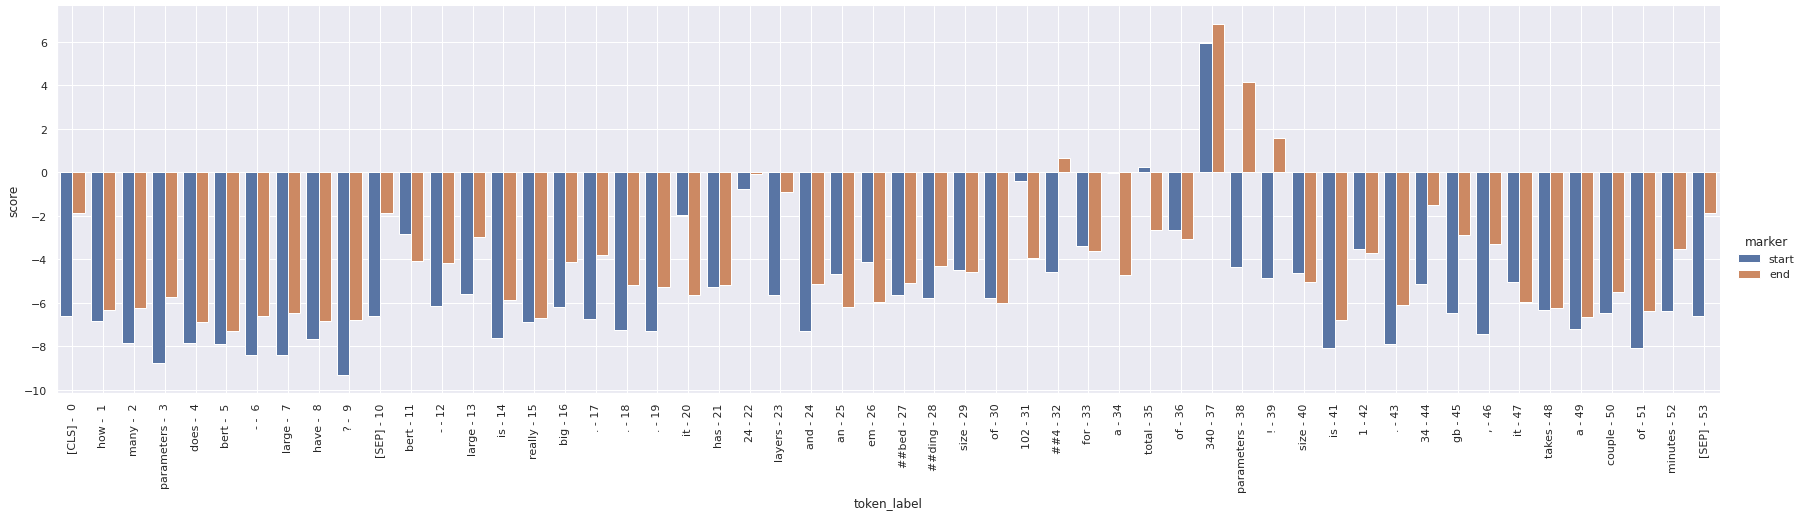

In [ ]:
g = sns.catplot(x="token_label", y="score", hue="marker",data=df, kind="bar", height=6, aspect=4)
g.set_xticklabels(g.ax.get_xticklabels(), rotation=90, ha="center")
g.ax.grid(True)

In [ ]:
# We can create a Function to turn Question Answering into a function


def answer_question(question, answer_text):
    '''
    Takes a `question` string and an `answer_text` string (which contains the
    answer), and identifies the words within the `answer_text` that are the
    answer. Prints them out.
    '''
    # ======== Tokenize ========
    # Apply the tokenizer to the input text, treating them as a text-pair.
    input_ids = tokenizer.encode(question, answer_text)

    # Report how long the input sequence is.
    print('Query has {:,} tokens.\n'.format(len(input_ids)))

    # ======== Set Segment IDs ========
    # Search the input_ids for the first instance of the `[SEP]` token.
    sep_index = input_ids.index(tokenizer.sep_token_id)

    # The number of segment A tokens includes the [SEP] token istelf.
    num_seg_a = sep_index + 1

    # The remainder are segment B.
    num_seg_b = len(input_ids) - num_seg_a

    # Construct the list of 0s and 1s.
    segment_ids = [0]*num_seg_a + [1]*num_seg_b

    # There should be a segment_id for every input token.
    assert len(segment_ids) == len(input_ids)

    # ======== Evaluate ========
    # Run our example question through the model.
    start_scores, end_scores = model(torch.tensor([input_ids]), # The tokens representing our input text.
                                    token_type_ids=torch.tensor([segment_ids])) # The segment IDs to differentiate question from answer_text

    # ======== Reconstruct Answer ========
    # Find the tokens with the highest `start` and `end` scores.
    answer_start = torch.argmax(start_scores)
    answer_end = torch.argmax(end_scores)

    # Get the string versions of the input tokens.
    tokens = tokenizer.convert_ids_to_tokens(input_ids)

    # Start with the first token.
    answer = tokens[answer_start]

    # Select the remaining answer tokens and join them with whitespace.
    for i in range(answer_start + 1, answer_end + 1):
        
        # If it's a subword token, then recombine it with the previous token.
        if tokens[i][0:2] == '##':
            answer += tokens[i][2:]
        
        # Otherwise, add a space then the token.
        else:
            answer += ' ' + tokens[i]

    print('Answer: "' + answer + '"')

In [ ]:
#Let's take Abstract of BERT Paper
#Text Wrap is used for wrapping and formatting of plain text

import textwrap 
wrapper = textwrap.TextWrapper(width=80)
bert_abstract = "We introduce a new language representation model called BERT, which stands for Bidirectional Encoder Representations from Transformers. Unlike recent language representation models (Peters et al., 2018a; Radford et al., 2018), BERT is designed to pretrain deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context in all layers. As a result, the pre-trained BERT model can be finetuned with just one additional output layer to create state-of-the-art models for a wide range of tasks, such as question answering and language inference, without substantial taskspecific architecture modifications. BERT is conceptually simple and empirically powerful. It obtains new state-of-the-art results on eleven natural language processing tasks, including pushing the GLUE score to 80.5% (7.7% point absolute improvement), MultiNLI accuracy to 86.7% (4.6% absolute improvement), SQuAD v1.1 question answering Test F1 to 93.2 (1.5 point absolute improvement) and SQuAD v2.0 Test F1 to 83.1 (5.1 point absolute improvement)."

print(wrapper.fill(bert_abstract))
#Abstract from BERT

We introduce a new language representation model called BERT, which stands for
Bidirectional Encoder Representations from Transformers. Unlike recent language
representation models (Peters et al., 2018a; Radford et al., 2018), BERT is
designed to pretrain deep bidirectional representations from unlabeled text by
jointly conditioning on both left and right context in all layers. As a result,
the pre-trained BERT model can be finetuned with just one additional output
layer to create state-of-the-art models for a wide range of tasks, such as
question answering and language inference, without substantial taskspecific
architecture modifications. BERT is conceptually simple and empirically
powerful. It obtains new state-of-the-art results on eleven natural language
processing tasks, including pushing the GLUE score to 80.5% (7.7% point absolute
improvement), MultiNLI accuracy to 86.7% (4.6% absolute improvement), SQuAD v1.1
question answering Test F1 to 93.2 (1.5 point absolute improvement) 

In [ ]:
#Let's ask a question in BERT 
question = "What does the 'B' in BERT stand for?"

answer_question(question, bert_abstract)

Query has 258 tokens.

Answer: "bidirectional encoder representations from transformers"


In [ ]:
#Let's ask BERT about example applications of itself 

question = "What are some example applications of BERT?"
answer_question(question, bert_abstract)

Query has 255 tokens.

Answer: "question answering and language inference"


In [ ]:
question = "How many natural language processing task BERT obtains state-of-the-art results?"
answer_question(question, bert_abstract)

Query has 265 tokens.

Answer: "eleven"
